In [1]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_init/exactsolutions.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")

MPAS_Ocean_CUDA

# Load Mesh From File

In [2]:
mpasOcean = MPAS_Ocean(CODE_ROOT * "InertiaGravityWaveMesh",
                "base_mesh.nc", "mesh.nc", periodicity="Periodic", nvlevels=1)
mpasOcean.nCells, mpasOcean.nVertLevels

(10000, 1)

# Define Initial Condition

In [3]:
etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasOcean, 1, 2, 1e-2)

inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, 0.0)

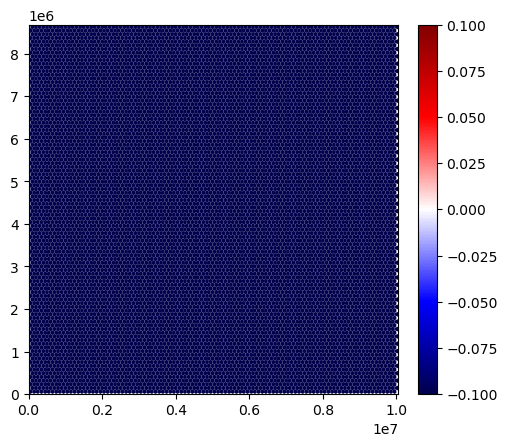

In [4]:
fig, ax, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Benchmark GPU vs CPU

In [5]:
mpasOceanCuda = MPAS_Ocean_CUDA(mpasOcean)
fieldnames(typeof(mpasOceanCuda))

LoadError: CUDA error (code 999, CUDA_ERROR_UNKNOWN)

In [15]:
using BenchmarkTools

In [ ]:
# benchmark time it takes to do a timestep on the CPU
inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, 0.0)

cpubench = @benchmark forward_backward_step!(mpasOcean) samples=100

In [ ]:
# benchmark time it takes to do a timestep on the GPU
inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, 0.0)
mpasOceanCuda = MPAS_Ocean_CUDA(mpasOcean)
gpubench = @benchmark begin
    CUDA.@sync begin
        forward_backward_step_cuda!(mpasOceanCuda)
    end
end samples=10000

In [82]:
cpucum = cumsum(cpubench.times)

10-element Vector{Float64}:
 865926.0
      1.676497e6
      2.473574e6
      3.2671e6
      4.060164e6
      4.853269e6
      5.706649e6
      6.541495e6
      7.334479e6
      8.127696e6

In [83]:
gpucum = cumsum(gpubench.times)

10-element Vector{Float64}:
 10161.5
 15890.333333333332
 21639.5
 28011.0
 33741.33333333333
 39379.83333333333
 45031.5
 50759.833333333336
 56383.333333333336
 62020.16666666667

In [74]:
open(CODE_ROOT * "output/cpubenchmark.txt", "w") do file
    writedlm(file, [string(cpubench.params), cpubench.times, cpubench.gctimes, cpubench.memory, cpubench.allocs])
end

In [48]:
open(CODE_ROOT * "output/gpubenchmark.txt", "w") do file
    writedlm(file, [string(gpubench.params), gpubench.times, gpubench.gctimes, gpubench.memory, gpubench.allocs])
end

### normal velocty tendency calculation only

In [22]:
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]

cpubench = @benchmark calculate_normal_velocity_tendency!(mpasOcean)

BechmarkTools.Trial: 307 samples with 1 evaluations.
 Range (min … max):  14.158 ms … 21.202 ms  ┊ GC (min … max): 0.00% … 19.17%
 Time  (median):     15.531 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.294 ms ±  1.730 ms  ┊ GC (mean ± σ):  6.43% ±  9.40%

          ▁█  ▄▆                                               
  ▄▃▄▃▅▄▄▆██▅████▆▅▅▁▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▃▃▃▃▄▃▄▃▆▅▅▃▄▂▃▂▂▄▄▂▂▂ ▃
  14.2 ms         Histogram: frequency by time        20.3 ms <

 Memory estimate: 13.24 MiB, allocs estimate: 725293.

In [21]:
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]
mpasOceanCuda = MPAS_Ocean_CUDA(mpasOcean)
gpubench = @benchmark begin
    CUDA.@sync begin
        calculate_normal_velocity_tendency_cuda!(mpasOceanCuda)
    end
end

BechmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):   4.501 μs … 743.442 μs  ┊ GC (min … max): 0.00% … 97.60%
 Time  (median):     20.223 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.198 μs ±  15.009 μs  ┊ GC (mean ± σ):  1.43% ±  1.95%

  ▃                                                   ▄█       ▁
  ██▄▃▁▁▄▄▄▁▄▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▃▁▁▁▃▁▁▁▁▃▄▄▅▇▇▆▆▆▆██▆▆▆▆▆▇ █
  4.5 μs        Histogram: log(frequency) by time      22.2 μs <

 Memory estimate: 3.08 KiB, allocs estimate: 57.

In [23]:
"CUDA kernel evaluation is $((sum(cpubench.times)/length(cpubench.times)) / (sum(gpubench.times)/length(gpubench.times))) times faster than the CPU evaluation on average"

"CUDA kernel evaluation is 806.7136301657602 times faster than the CPU evaluation on average"

### experimenting with making method more effecient

In [13]:
function calculate_normal_velocity_tendency_cuda2!(mpasOcean::MPAS_Ocean)
    
    CUDA.@cuda blocks=cld(mpasOcean.nEdges, 1024) threads=1024 maxregs=64 calculate_normal_velocity_tendency_cuda_kernel2!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityTendency,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.cellsOnEdge,
                                                                        mpasOcean.nEdgesOnEdge,
                                                                        mpasOcean.edgesOnEdge,
                                                                        mpasOcean.weightsOnEdge,
                                                                        mpasOcean.fEdge,
                                                                        mpasOcean.dcEdge,
                                                                        mpasOcean.gravity)
end

calculate_normal_velocity_tendency_cuda2! (generic function with 1 method)

In [14]:
function calculate_normal_velocity_tendency_cuda_kernel2!(nEdges,
                                                          normalVelocityTendency,
                                                          normalVelocity,
                                                          ssh,
                                                          cellsOnEdge,
                                                          nEdgesOnEdge,
                                                          edgesOnEdge,
                                                          weightsOnEdge,
                                                          fEdge,
                                                          dcEdge,
                                                          gravity)
    
    iEdge = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
    if iEdge <= nEdges
        # read global memory into thread registers
        cell1 = cellsOnEdge[1,iEdge]
        ssh1 = ssh[cell1]
        cell2 = cellsOnEdge[2,iEdge]
        ssh2 = ssh[cell2]
        dc = dcEdge[iEdge]
        neoe = nEdgesOnEdge[iEdge]
        
#         eoes = edgesOnEdge[iEdge]
        
        
        
        # gravity term: take gradient of ssh across edge
        tendency = gravity * ( ssh1 - ssh2 ) / dc

        # coriolis term: combine norm. vel. of surrounding edges to approx. tangential vel.
        for i = 1:neoe
            eoe = edgesOnEdge[i,iEdge]
            tendency += weightsOnEdge[i,iEdge] * normalVelocity[eoe] * fEdge[eoe]
        end

        normalVelocityTendency[iEdge] = tendency
    end
    return
end

calculate_normal_velocity_tendency_cuda_kernel2! (generic function with 1 method)

In [15]:
function calculate_ssh_tendency_cuda_kernel2!(nCells,
                                              sshTendency,
                                              ssh,
                                              normalVelocity,
                                              bottomDepth,
                                              nEdgesOnCell,
                                              edgesOnCell,
                                              cellsOnCell,
                                              areaCell,
                                              edgeSignOnCell,
                                              dvEdge)
    
    iCell = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
    if iCell <= nCells
        
        sshTendency[iCell] = 0
        
        # sum flux through each edge of cell
        for i in 1:nEdgesOnCell[iCell]
            edgeID = edgesOnCell[i,iCell]
            neighborCellID = cellsOnCell[i,iCell]

            if neighborCellID !== 0
                depth = ( bottomDepth[neighborCellID] + bottomDepth[iCell] ) / 2.0
            else
                depth = bottomDepth[iCell]
            end
            
            flux = depth * normalVelocity[edgeID]
            sshTendency[iCell] += flux * edgeSignOnCell[iCell,i] * dvEdge[edgeID] / areaCell[iCell]
        end
        
    end
    return
end


calculate_ssh_tendency_cuda_kernel2! (generic function with 1 method)

In [16]:
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]
moveArrays!(mpasOcean, CUDA.CuArray)
gpubench = @benchmark calculate_normal_velocity_tendency_cuda2!(mpasOcean)

BechmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):   4.347 μs … 732.013 μs  ┊ GC (min … max): 0.00% … 97.58%
 Time  (median):     16.960 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.270 μs ±  14.179 μs  ┊ GC (mean ± σ):  1.50% ±  1.95%

  ▃                ▂█                                          ▁
  █▅▄▆▄▄▃▄▄▅▅▅▅▇▇██████▇▇▅▅▄▄▄▄▃▄▁▄▁▃▄▄▅▄▃▃▃▃▃▄▄▅▅▅▄▁▁▁▁▁▃▄▅▅▃ █
  4.35 μs       Histogram: log(frequency) by time      45.9 μs <

 Memory estimate: 3.08 KiB, allocs estimate: 57.

17 microseconds rather than 20, a slight improvement

### ssh tendency calculation only

In [25]:
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]
moveArrays!(mpasOcean, CUDA.CuArray)
gpubench = @benchmark calculate_ssh_tendency_cuda!(mpasOcean)

BechmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):   4.374 μs … 760.519 μs  ┊ GC (min … max): 0.00% … 96.73%
 Time  (median):     27.183 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   27.210 μs ±  14.107 μs  ┊ GC (mean ± σ):  0.81% ±  1.69%

  ▃                         █                                  ▁
  █▄▄▃▁▃▃▁▁▁▁▃▁▁▁▁▁▁▃▃▁▃▄▇████▇▄▄▁▁▁▁▁▁▁▁▁▄▁▁▃▄▄▃▁▁▁▁▁▁▄▁▅▆▄▃▆ █
  4.37 μs       Histogram: log(frequency) by time      56.2 μs <

 Memory estimate: 3.11 KiB, allocs estimate: 55.

In [26]:
moveArrays!(mpasOcean, Array)
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]
cpubench = @benchmark calculate_ssh_tendency!(mpasOcean)

BechmarkTools.Trial: 1283 samples with 1 evaluations.
 Range (min … max):  3.539 ms …   7.596 ms  ┊ GC (min … max): 0.00% … 41.13%
 Time  (median):     3.672 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.895 ms ± 746.883 μs  ┊ GC (mean ± σ):  5.31% ± 11.34%

  ▂▆█▄▄▃                                                ▁      
  ██████▇▅▆▆▁▁▄▄▄▄▄▁▁▅▆▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇███▇▇▆ █
  3.54 ms      Histogram: log(frequency) by time      6.69 ms <

 Memory estimate: 3.81 MiB, allocs estimate: 229892.

In [27]:
"CUDA kernel evaluation is $((sum(cpubench.times)/length(cpubench.times)) / (sum(gpubench.times)/length(gpubench.times))) times faster than the CPU evaluation on average"

"CUDA kernel evaluation is 143.1461720325683 times faster than the CPU evaluation on average"

### update norm vel

In [28]:
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]
moveArrays!(mpasOcean, CUDA.CuArray)
gpubench = @benchmark update_normal_velocity_by_tendency_cuda!(mpasOcean)

BechmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  3.152 μs … 735.304 μs  ┊ GC (min … max): 0.00% … 99.27%
 Time  (median):     3.337 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.535 μs ±  10.279 μs  ┊ GC (mean ± σ):  4.10% ±  1.40%

     ██▇▅▁                                                     
  ▂▂▆█████▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂ ▃
  3.15 μs         Histogram: frequency by time        5.14 μs <

 Memory estimate: 1.39 KiB, allocs estimate: 33.

In [29]:
moveArrays!(mpasOcean, Array)
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]
cpubench = @benchmark update_normal_velocity_by_tendency!(mpasOcean)

BechmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.454 μs …   5.509 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.545 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.580 μs ± 286.345 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▃▂█▁                                                        
  ▆████▄▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▂
  1.45 μs         Histogram: frequency by time        3.14 μs <

 Memory estimate: 80 bytes, allocs estimate: 3.

In [30]:
"CUDA kernel evaluation is $((sum(cpubench.times)/length(cpubench.times)) / (sum(gpubench.times)/length(gpubench.times))) times faster than the CPU evaluation on average"

"CUDA kernel evaluation is 0.44711592195483957 times faster than the CPU evaluation on average"

### update ssh

In [31]:
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]
moveArrays!(mpasOcean, CUDA.CuArray)
gpubench = @benchmark update_ssh_by_tendency_cuda!(mpasOcean)

BechmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  3.021 μs … 729.140 μs  ┊ GC (min … max): 0.00% … 99.33%
 Time  (median):     3.220 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.348 μs ±   7.266 μs  ┊ GC (mean ± σ):  2.16% ±  0.99%

     ▃██▆▄▁                                                    
  ▂▃▆██████▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂ ▃
  320 μs          Histogram: frequency by time        4.94 μs <

 Memory estimate: 1.39 KiB, allocs estimate: 33.

In [32]:
moveArrays!(mpasOcean, Array)
mpasOcean.sshCurrent[:] = initialSSH[:]
mpasOcean.normalVelocityCurrent[:] = initialNormalVelocity[:]
cpubench = @benchmark update_ssh_by_tendency!(mpasOcean)

BechmarkTools.Trial: 10000 samples with 162 evaluations.
 Range (min … max):  664.253 ns …  27.238 μs  ┊ GC (min … max): 0.00% … 97.05%
 Time  (median):     713.883 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   722.487 ns ± 371.018 ns  ┊ GC (mean ± σ):  0.72% ±  1.37%

           ▁▂▃▄█▇▃▂▁                                             
  ▂▂▃▄▄▆█▇▇█████████▇▇▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂ ▃
  664 ns           Histogram: frequency by time          885 ns <

 Memory estimate: 80 bytes, allocs estimate: 3.

In [33]:
"CUDA kernel evaluation is $((sum(cpubench.times)/length(cpubench.times)) / (sum(gpubench.times)/length(gpubench.times))) times faster than the CPU evaluation on average"

"CUDA kernel evaluation is 0.21581601461375574 times faster than the CPU evaluation on average"

the data copying step is actually 2 - 5 times slower than it is on the CPU! Memory is the bottleneck of the GPU